## Optimization

This section covers some budget optimization strategy by leveraging a fitted MMM.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning import TargetMaximizer, calculate_marginal_cost
from karpiu.explainability import Attributor

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open ('./resource/model.pkl', 'rb') as f:
    mmm = pickle.load(f)

In [4]:
budget_start = pd.to_datetime('2021-01-01')
budget_end = pd.to_datetime('2021-01-31')
optim_channels = mmm.get_spend_cols()
# to be safe in beta version, use sorted list of channels
optim_channels.sort()

# spend_scaler a fixed constant to reduce over-float of spend
# not that they need to be consistent with the subsequent calculation of 
# post optimization metrics
spend_scaler = 1e3

In [16]:
# report average and marginal cost
attr_obj = Attributor(mmm, attr_regressors=optim_channels, start=budget_start, end=budget_end)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()
tot_attr_df = spend_attr_df[optim_channels].apply(np.sum, axis=0)
tot_spend_df = spend_df[optim_channels].apply(np.sum, axis=0)
avg_cost_df = tot_spend_df / tot_attr_df
avg_cost_df = pd.DataFrame(avg_cost_df)
avg_cost_df.index = avg_cost_df.index.rename("regressor")
avg_cost_df = avg_cost_df.rename(columns={0: "avg_cost"})

tot_spend_df = tot_spend_df / spend_scaler
tot_spend_df = pd.DataFrame(tot_spend_df)
tot_spend_df.index = tot_spend_df.index.rename("regressor")
tot_spend_df = tot_spend_df.rename(columns={0: "pre_opt_spend"})

In [17]:
mc_df = calculate_marginal_cost(
    mmm,
    channels=optim_channels, 
    spend_start=budget_start, 
    spend_end=budget_end, 
)

In [20]:
pre_opt_report = pd.concat([avg_cost_df, mc_df, tot_spend_df], axis=1, keys='regressor')
pre_opt_report.columns = ['pre-opt-avg-cost', 'pre-opt-marginal-cost', 'pre-opt-spend']
pre_opt_report

,pre-opt-avg-cost,pre-opt-marginal-cost,pre-opt-spend
regressor,,,
promo,39.85150,51.75797,41.01600
radio,63.41924,85.70248,131.89400
search,57.88063,50.24106,17.77200
social,52.19144,70.36769,81.93300
tv,159.76884,205.03113,225.00900


In [21]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channel=optim_channels, 
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3082.5371087322446
            Iterations: 87
            Function evaluations: 13694
            Gradient evaluations: 87


In [22]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [23]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 497624
Total Budget: 497624


## Diagnostic

### Budget Allocation

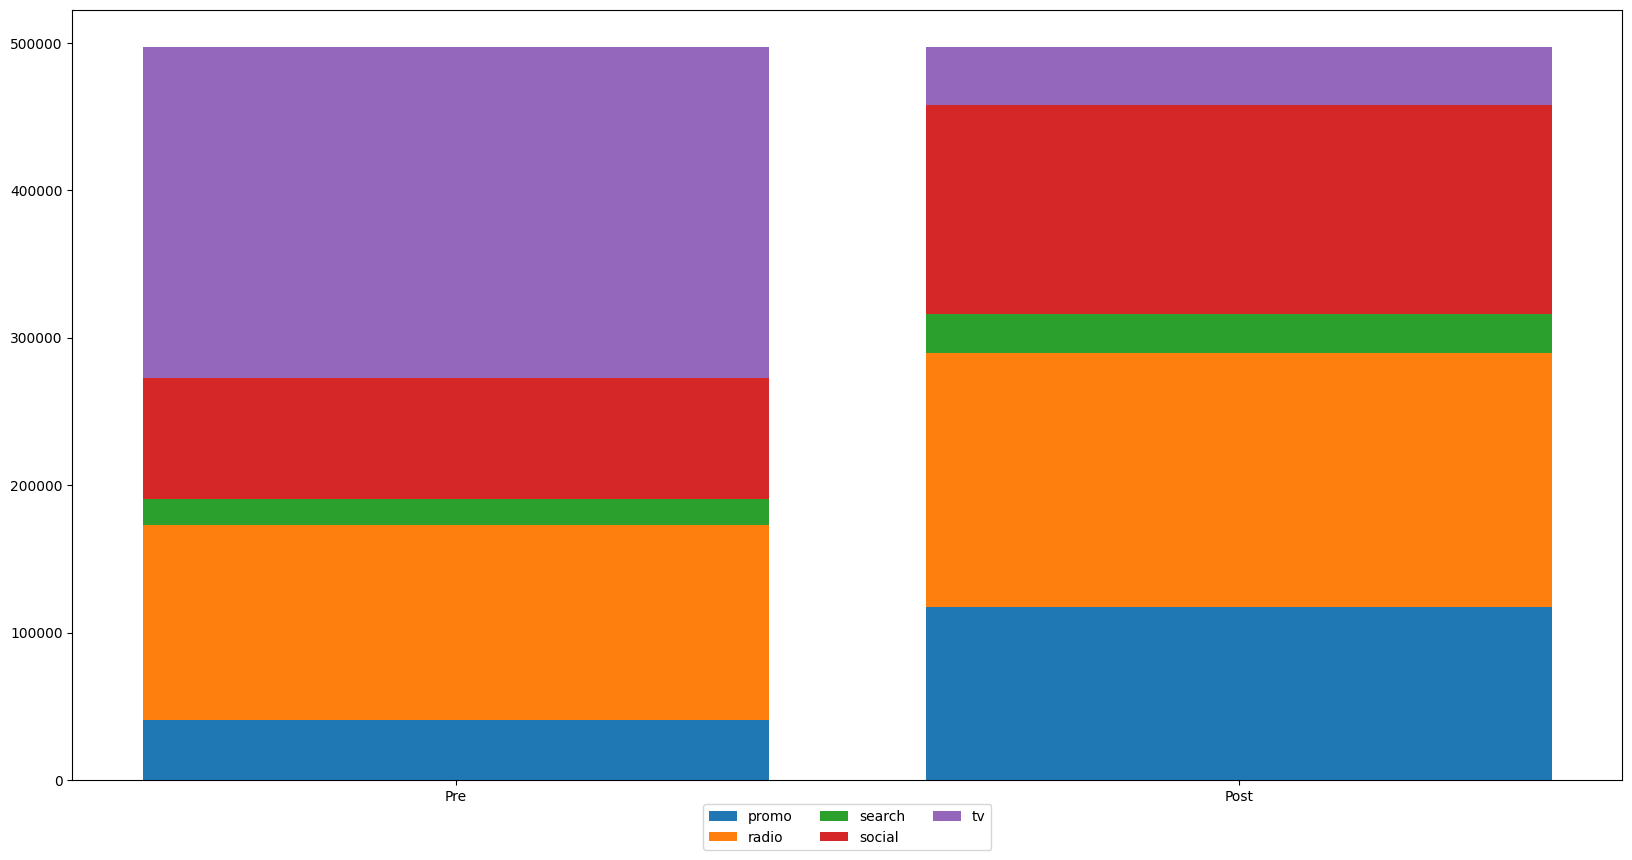

In [24]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=['Pre', 'Post'], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.10), ncol=math.ceil(len(optim_channels)/2));

In [25]:
post_mc_df = calculate_marginal_cost(
    mmm,
    channels=mmm.get_spend_cols(), 
    spend_start=budget_start, 
    spend_end=budget_end, 
    spend_df=optim_spend_df,
)

In [26]:
attr_obj = Attributor(mmm, df=optim_spend_df, attr_regressors=optim_channels, start=budget_start, end=budget_end)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()
optim_tot_attr_df = spend_attr_df[optim_channels].apply(np.sum, axis=0)
optim_tot_spend_df = spend_df[optim_channels].apply(np.sum, axis=0)
post_avg_cost_df = optim_tot_spend_df / optim_tot_attr_df
post_avg_cost_df = pd.DataFrame(post_avg_cost_df)
post_avg_cost_df = post_avg_cost_df.rename(columns={0: "post-opt-avg-cost"})

optim_tot_spend_df = optim_tot_spend_df / spend_scaler
optim_tot_spend_df = pd.DataFrame(optim_tot_spend_df)
optim_tot_spend_df.index = optim_tot_spend_df.index.rename("regressor")
optim_tot_spend_df = optim_tot_spend_df.rename(columns={0: "post-opt-spend"})

### Average and Marginal Cost Change

In [29]:
post_opt_report = pd.concat([post_avg_cost_df, post_mc_df, optim_tot_spend_df], axis=1)
post_opt_report.columns = ['post-opt-avg-cost', 'post-opt-marginal-cost', 'post-opt-spend']
post_opt_report

,post-opt-avg-cost,post-opt-marginal-cost,post-opt-spend
promo,62.86880,104.22215,117.53206
radio,72.32289,104.26011,172.16142
search,49.07924,103.84767,26.63252
social,68.66065,104.24514,141.87068
tv,85.43986,106.24109,39.42732


In [31]:
opt_report = pd.concat([pre_opt_report, post_opt_report], axis=1)
opt_report = opt_report[[
    "pre-opt-avg-cost", "post-opt-avg-cost", "pre-opt-marginal-cost",
    "post-opt-marginal-cost", "pre-opt-spend", "post-opt-spend"]
]
opt_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend
promo,39.85150,62.86880,51.75797,104.22215,41.01600,117.53206
radio,63.41924,72.32289,85.70248,104.26011,131.89400,172.16142
search,57.88063,49.07924,50.24106,103.84767,17.77200,26.63252
social,52.19144,68.66065,70.36769,104.24514,81.93300,141.87068
tv,159.76884,85.43986,205.03113,106.24109,225.00900,39.42732


In [56]:
 opt_report["post-opt-marginal-cost"] / np.nanmean(opt_report["post-opt-marginal-cost"])

promo    0.99674
radio    0.99710
search   0.99316
social   0.99696
tv       1.01605
Name: post-opt-marginal-cost, dtype: float64

In [63]:
# check 1: all marginal cost should be close; within 1% of median
assert np.all(np.abs(
    opt_report["post-opt-marginal-cost"].values /
    np.nanmean(opt_report["post-opt-marginal-cost"].values) - 1.00)
 < 0.05)

### Outcome Plot

In [47]:
df = mmm.get_raw_df()
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)

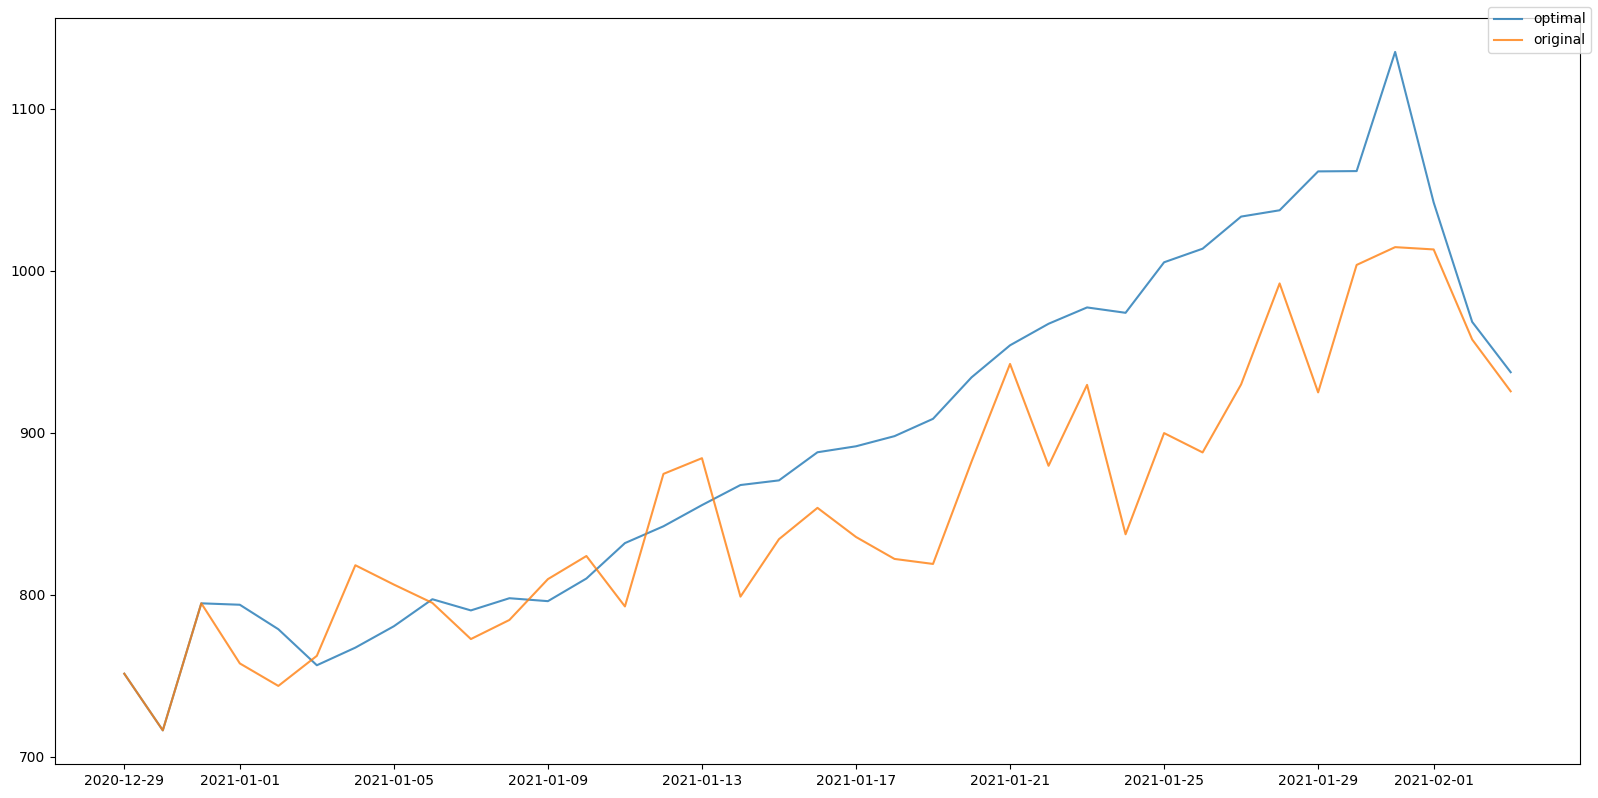

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
measurement_mask = (df['date'] >= maximizer.calc_start) & (df['date'] <= maximizer.calc_end)
ax.plot(
    optim_pred.loc[measurement_mask, 'date'].values, 
    optim_pred.loc[measurement_mask, 'prediction'].values, 
    label='optimal', 
    alpha=0.8,
)
ax.plot(
    init_pred.loc[measurement_mask, 'date'].values,
    init_pred.loc[measurement_mask, 'prediction'].values,
    label='original', 
    alpha=0.8,
)
fig.legend()
fig.tight_layout();

In [80]:
# check2: total predicted response must be higher than current
total_optim_pred = np.sum(optim_pred.loc[measurement_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[measurement_mask, "prediction"].values)
assert total_optim_pred > total_init_pred